## Bayesian Optimization

# Feature Engineering

In [4]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [5]:
from scipy.stats.mstats import winsorize

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos.  
Se usa como índice building_id para train_values y train_labels  

In [6]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [7]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

## Información de los datasets

In [8]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [9]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [10]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


# Aplicamos transformaciones

In [11]:
# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

In [12]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# this function takes a dataframe as input and
# returns a modified version thereof
def select_columns_iloc(input_df,range_columns):
    output_df = input_df.iloc[:,range_columns[0]:range_columns[1]]
    return output_df

def drop_columns(input_df,columns):
    output_df = input_df.copy()
    for column_name in columns:
        output_df = output_df.drop(labels=column_name,axis=1)
    return output_df

def winsorize_columns(input_df,columns_to_winsorize,ranges_winsorize):
    for i in range(len(columns_to_winsorize)):
        columna_winsorize = winsorize(input_df[columns_to_winsorize[i]],ranges_winsorize[i])
        input_df[columns_to_winsorize[i]] = columna_winsorize
    return input_df

def get_dummies_transform(input_df):
    return pd.get_dummies(input_df)

#auxiliar
def nombre_nueva_mean_col(col_name,damage_grade):
    damage_names = {1:'low',2:'medium',3:'high'}
    return 'mean_'+damage_names[damage_grade]+'_damage_'+col_name

#generalizar para una columna
def agregar_col_mean_daño_por_columna(input_df,labels_df,col_name,damage_grade):
    """Agrega una columna llamada mean_damage_'col_name' con el mean damage para el daño 'damage_grade'"""
    work_df = input_df[[col_name]].copy()
    work_df = work_df.join(labels_df,on='building_id',how='inner')
    work_df['count_damage_i'] = work_df['damage_grade'] == damage_grade
    new_col_name = nombre_nueva_mean_col(col_name,damage_grade)
    input_df[new_col_name] = work_df.groupby(col_name).transform('mean')['count_damage_i']
    return input_df


In [13]:
#Ajustes iniciales
pipeline_inicial = Pipeline([
    ("drop_has_sec_variants", FunctionTransformer(select_columns_iloc,kw_args={'range_columns':(0,28)})),
    ("drop_plan_config", FunctionTransformer(drop_columns,kw_args={'columns': ['plan_configuration']})),
    ("winsorize", FunctionTransformer(winsorize_columns,kw_args={'columns_to_winsorize': ['age','area_percentage','height_percentage'],
                                                                'ranges_winsorize': [(0,0.03),(0,0.03),(0,0.06)]})),
])
# Probar al final si sacarlos obtengo mejor score.

In [14]:
#Mean col geo
steps_daños = []
for geo_level_id in range(1,4):
    for damage_grade in range(1,4):
        nombre_step = 'add_damage_'+str(damage_grade)+'_geo_'+str(geo_level_id)
        args = {'labels_df': train_labels,'col_name': 'geo_level_'+str(geo_level_id)+'_id','damage_grade':damage_grade}
        steps_daños.append((nombre_step,FunctionTransformer(agregar_col_mean_daño_por_columna,kw_args=args)))

In [15]:
pipeline_daños = Pipeline(steps=steps_daños)
#pipeline_daños

In [16]:
#Mean col area
steps_area = []
for damage_grade in range(1,4):
    nombre_step = 'add_damage_'+str(damage_grade)+'_height'
    args = {'labels_df': train_labels,'col_name': 'area_percentage','damage_grade':damage_grade}
    steps_area.append((nombre_step,FunctionTransformer(agregar_col_mean_daño_por_columna,kw_args=args)))

In [17]:
pipeline_area= Pipeline(steps=steps_area)

### Aplico transformaciones

In [18]:
train_values_transformado = pipeline_inicial.fit_transform(train_values)

In [19]:
train_values_transformado = pipeline_daños.fit_transform(train_values_transformado)

In [20]:
train_values_transformado = pipeline_area.fit_transform(train_values_transformado)

In [21]:
train_values_transformado = pd.get_dummies(train_values_transformado)

In [22]:
train_values_transformado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 60 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          260601 non-null  int16  
 1   geo_level_2_id                          260601 non-null  int16  
 2   geo_level_3_id                          260601 non-null  int16  
 3   count_floors_pre_eq                     260601 non-null  int16  
 4   age                                     260601 non-null  int16  
 5   area_percentage                         260601 non-null  int16  
 6   height_percentage                       260601 non-null  int16  
 7   has_superstructure_adobe_mud            260601 non-null  bool   
 8   has_superstructure_mud_mortar_stone     260601 non-null  bool   
 9   has_superstructure_stone_flag           260601 non-null  bool   
 10  has_superstructure_cement_mortar_stone 

XGBoost

In [23]:
import xgboost as xgb
import time
from datetime import datetime
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import sys

In [22]:
from sklearn.utils.class_weight import compute_sample_weight

## Inicio del algoritmo


In [28]:
space = {
        'n_estimators':hp.choice('n_estimators', np.arange(100, 400, 10, dtype=int)),
        'max_depth':hp.choice('max_depth', np.arange(6,14, 1, dtype=int)),
        'gamma':hp.quniform('gamma', 0, 5, 0.5),
        'max_delta_step':hp.choice('max_delta_step', np.arange(0,5, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(0.5, 3, 0.5, dtype=int)),
        'subsample':hp.quniform('subsample', 0.5, 1, 0.1),
        'eta':hp.quniform('eta', 0.1, 1, 0.1),
        'objective':'multi:softmax',
        'eval_metric': 'mlogloss',
    }

In [29]:
important_parameters = ['n_estimators','max_depth','colsample_bytree','min_child_weight','subsample','eta']

In [30]:
def objective_function(params):
    clf = xgb.XGBClassifier(**params)
    score = cross_val_score(clf, train_values_transformado, train_labels.values.ravel(), cv=5,verbose=10).mean()
    #Save best params now
    mensaje_output = f'{datetime.now().strftime("%d/%m/%Y, %H:%M:%S")} --- Score: {score}--- ---'
    params = clf.get_params()
    local_opt = []
    for parameter in important_parameters:
        local_opt.append((parameter,params.get(parameter)))
    with open('best_param_allnight.txt',mode='a') as fd:
        fd.write(mensaje_output+'\n')
        fd.write(f"Parametros-{str(local_opt)}")
        fd.write("\n")
    print(mensaje_output)
    return {'loss': -score, 'status': STATUS_OK}

In [31]:
trials = Trials()

In [ ]:
best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=120, trials=trials)

In [ ]:
print(best_param)

In [ ]:
pprint(trials.trials)

## Se guarda los intentos en un archivo

In [1]:
import pickle

In [2]:
#pickle.dump(trials, open("hyperopt.p", "wb"))
trials = pickle.load(open("hyperopt.p", "rb"))

In [3]:
trials

In [24]:
def unpack(x):
    if x:
        return x[0]
    return np.nan
# We'll first turn each trial into a series and then stack those series together as a dataframe.
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials.trials[:-1]])
# Then we'll add other relevant bits of information to the correct rows and perform a couple of
# mappings for convenience
# Notar que se usa trials [:-1] por que hubo un error en el último intento (se detuvo antes)
trials_df["loss"] = [t["result"]["loss"] for t in trials.trials[:-1]]
trials_df["trial_number"] = trials_df.index

In [25]:
pd.options.display.float_format = "{:,.4f}".format

In [26]:
trials_df["n_estimators"] = trials_df["n_estimators"].apply(lambda x:(x+10)*10)
trials_df["max_depth"] = trials_df["max_depth"].apply(lambda x:x+6)
trials_df = trials_df.rename(columns={'loss':'score','eta':'learning_rate'})
trials_df = trials_df.set_index('trial_number')

In [27]:
trials_df[['score','max_depth','n_estimators','learning_rate','gamma','subsample','max_delta_step','colsample_bytree','min_child_weight']].sort_values('score').head(10)

,score,max_depth,n_estimators,learning_rate,gamma,subsample,max_delta_step,colsample_bytree,min_child_weight
trial_number,,,,,,,,,
21,-0.7630,13.0000,330.0000,0.1000,5.0000,0.9000,1.0000,0.5000,1.0000
36,-0.7629,9.0000,340.0000,0.1000,3.0000,0.9000,0.0000,0.9000,2.0000
3,-0.7627,9.0000,330.0000,0.1000,2.5000,0.9000,4.0000,1.0000,2.0000
31,-0.7626,13.0000,130.0000,0.1000,4.5000,0.8000,1.0000,0.8000,3.0000
22,-0.7626,10.0000,330.0000,0.1000,5.0000,0.9000,1.0000,0.8000,1.0000
37,-0.7622,13.0000,340.0000,0.1000,3.5000,0.9000,0.0000,0.9000,0.0000
42,-0.7622,12.0000,290.0000,0.2000,5.0000,0.9000,1.0000,1.0000,0.0000
32,-0.7621,10.0000,150.0000,0.3000,5.0000,0.9000,3.0000,0.6000,1.0000
26,-0.7620,9.0000,100.0000,0.1000,4.5000,0.9000,4.0000,0.6000,1.0000


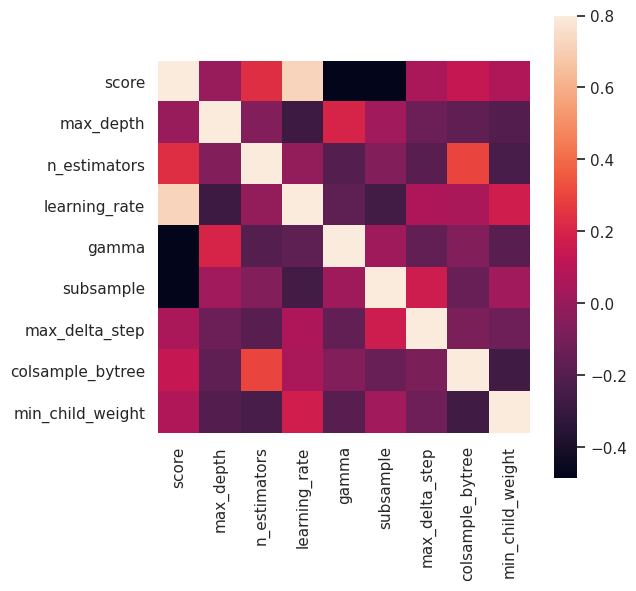

In [28]:
corrmat = trials_df[['score','max_depth','n_estimators','learning_rate','gamma','subsample','max_delta_step','colsample_bytree','min_child_weight']].corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax=.8, square=True);

array([<AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>], dtype=object)

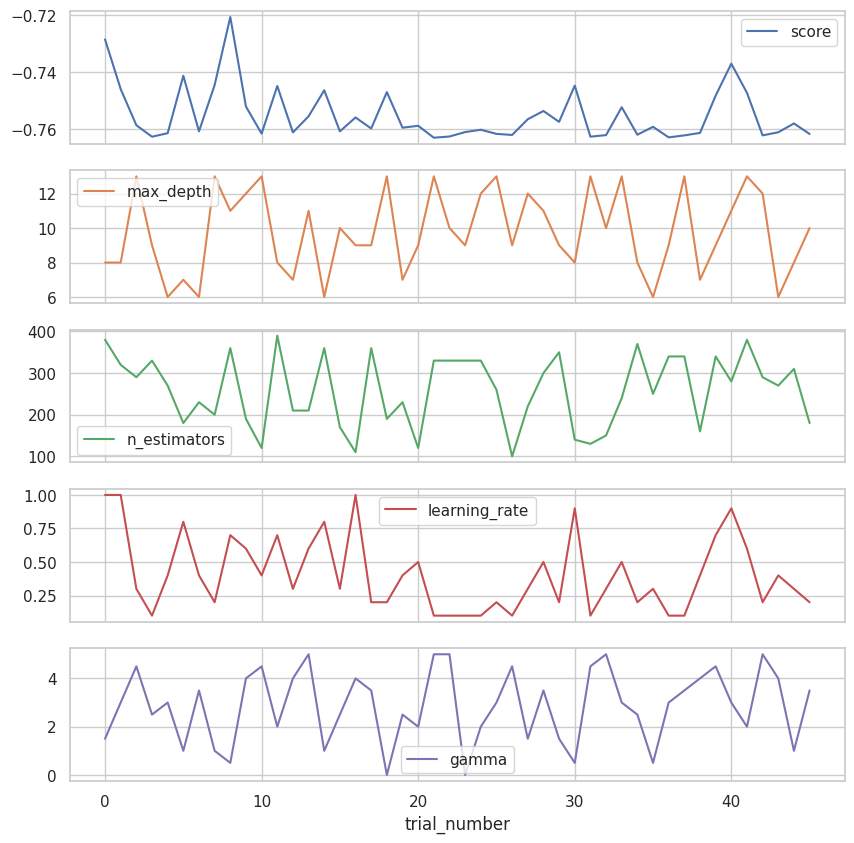

In [29]:
trials_df[['score','max_depth','n_estimators','learning_rate','gamma']].plot(subplots=True,figsize=(10,10))

array([<AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>,
       <AxesSubplot:xlabel='trial_number'>], dtype=object)

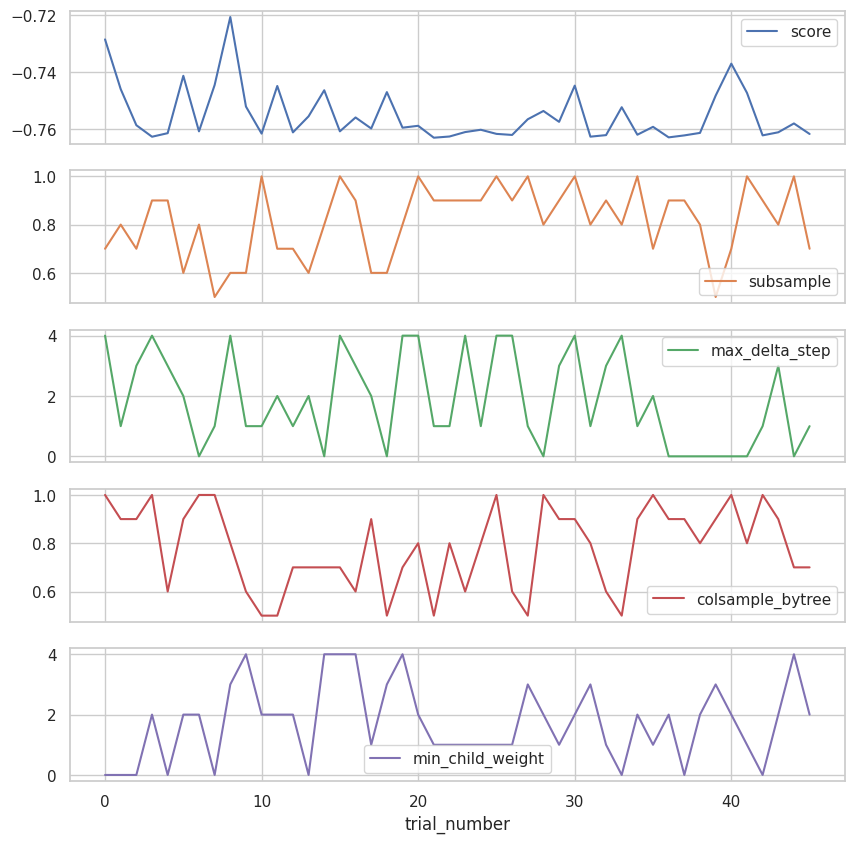

In [30]:
trials_df[['score','subsample','max_delta_step','colsample_bytree','min_child_weight']].plot(subplots=True,figsize=(10,10))